# Install Transformers Library

In [ ]:
# !pip install transformers
# !pip install --upgrade transformers
# from transformers import __version__; print(__version__)

In [1]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset

In [18]:
data_yt01 = pd.read_csv('D:\skyline project\Projects\week1\dataset\youtube_video_comments\Youtube01-Psy.csv')
data_yt02 = pd.read_csv('D:\skyline project\Projects\week1\dataset\youtube_video_comments\Youtube02-KatyPerry.csv')
data_yt03 = pd.read_csv('D:\skyline project\Projects\week1\dataset\youtube_video_comments\Youtube03-LMFAO.csv')
data_yt04 = pd.read_csv('D:\skyline project\Projects\week1\dataset\youtube_video_comments\Youtube04-Eminem.csv')
data_yt05 = pd.read_csv('D:\skyline project\Projects\week1\dataset\youtube_video_comments\Youtube05-Shakira.csv')
# merge all these dataframes into one dataframe
data = pd.concat([data_yt01, data_yt02, data_yt03, data_yt04, data_yt05])
# shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
# return all the datasets and the merged dataset
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13cztvzwlzawvszx04cfp3rdma0dlyonso0k,Maria Montana,2015-05-23T04:15:02.178000,"Awesome song!,congratulations!!!﻿",0
1,z13kszcinpnvc34v2234fnpxkpmlw3nhc04,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,1
2,z12iup4axsfpz50rz04cgr3xiuakujcwvb0,ΑΓΛΑΪΑ ΛΕΠΤΟΚΑΡΙΔΟΥ,2014-10-24T17:41:52,:-D ♪♪♪ This is my favorite song ♥﻿,0
3,z13xit5agm2zyh4f523rst2gowmbx5bml,Lone Twistt,2013-11-28T17:34:55,Once you have started reading do not stop. If...,1
4,z13pupugayfozd3zn04cc3kaim3qttfoh2s,Morgensen Freya,2014-10-13T21:50:51,follow me on twitter: freyacumqueen﻿,1


In [4]:
data.shape

(1956, 5)

In [5]:
data.dropna(inplace=True)

In [6]:
data.isna().sum()

COMMENT_ID    0
AUTHOR        0
DATE          0
CONTENT       0
CLASS         0
dtype: int64

In [7]:
# check class distribution
data['CLASS'].value_counts(normalize = True) 

0    0.555815
1    0.444185
Name: CLASS, dtype: float64

# Split train dataset into train, validation and test sets

In [19]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['CONTENT'], data['CLASS'], 
                                                                    random_state=2018, 
                                                                    test_size=0.4, 
                                                                    stratify=data['CLASS'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [9]:
train_text

207     My friend Sam loves this song😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊...
741                                       ILove shakira ﻿
13                   Check out this playlist on YouTube:﻿
1131    (( rapid facebook )) the free version of all c...
391                               Shakira u are so wiredo
                              ...                        
1801                                    very good song:)﻿
32      Check out  these Irish guys cover  of Avicii&#...
779                                     God she is so hot
1729    Hi everyone! My dream is to have passionate se...
121     http://thepiratebay.se/torrent/10626835/The.Ex...
Name: CONTENT, Length: 1197, dtype: object

In [10]:
test_text

437                               LMFAO best songs ever!﻿
56                             im still watching in 2015﻿
1134                                   just :( superr!!!﻿
1586    Check out this video on YouTube:Facebook lhudy...
231                                         NICE GIRL :D﻿
                              ...                        
1315                    this song never get's old &lt;3 ﻿
14                        most viewed video in the world﻿
1097       Rihanna is absolutely gorgeous in this video.﻿
1003                            You are the music hero😍😎﻿
1372                                    Party Rock<br />﻿
Name: CONTENT, Length: 257, dtype: object

In [11]:
print(type(test_text))
print(type(test_labels))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


# Import BERT Model and BERT Tokenizer

In [2]:
# import multilingual BERT base pretrained model
# bert = AutoModel.from_pretrained('bert-base-multilingual-cased')
# tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

bert_base_uncased = AutoModel.from_pretrained('bert-base-uncased')
# Load the multilingual BERT tokenizer
tokenizer_base_uncased = AutoTokenizer.from_pretrained('bert-base-uncased')


In [13]:
# sample data
sample_text = [" I always end up coming back to this song", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer_base_uncased.batch_encode_plus(sample_text, padding=True, return_token_type_ids=False)


In [14]:
# output
print(sent_id)

{'input_ids': [[101, 1045, 2467, 2203, 2039, 2746, 2067, 2000, 2023, 2299, 102], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [15]:
# encode the texts

encoded_dict = tokenizer_base_uncased.batch_encode_plus(sample_text, 
                                            add_special_tokens=True, 
                                            padding=True, 
                                            truncation=True, 
                                            max_length=10, 
                                            return_attention_mask=True, 
                                            return_tensors='pt')
# print the encoded output
print(encoded_dict)

{'input_ids': tensor([[  101,  1045,  2467,  2203,  2039,  2746,  2067,  2000,  2023,   102],
        [  101,  2057,  2097,  2986,  1011,  8694,  1037, 14324,  2944,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


# Tokenization

<Axes: >

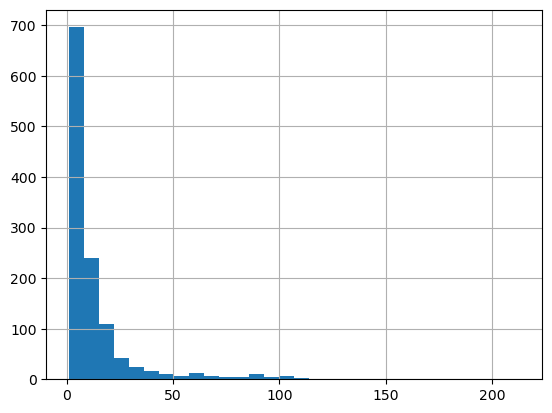

In [16]:
seq_len = []
for text in train_text:
    if isinstance(text, str):
        seq_len.append(len(text.split()))
pd.Series(seq_len).hist(bins=30)


In [21]:
max_seq_len = 500
# tokenize and encode sequences in the training set
tokens_train = tokenizer_base_uncased.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# tokenize and encode sequences in the validation set
tokens_val = tokenizer_base_uncased.batch_encode_plus(
    val_text.tolist(),
    #max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer_base_uncased.batch_encode_plus(
    test_text.tolist(),
    #max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

c:\Users\Lenovo\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [22]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [7]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors for the test set
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [3]:
# freeze all the parameters
for param in bert_base_uncased.parameters():
    param.requires_grad = False

# Define Model Architecture

In [4]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [7]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert_base_uncased)

# push the model to GPU
model = model.to(device)

In [34]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

c:\Users\Lenovo\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_labels)
class_wts = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)


print(class_wts)

[0.9   1.125]


In [36]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 1

# Fine-Tune BERT

In [37]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [38]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [39]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1

Evaluating...

Training Loss: 0.648
Validation Loss: 0.601


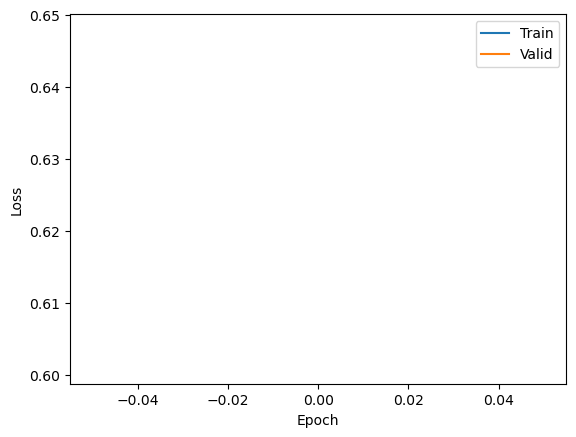

In [40]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Model Testing

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert_base_uncased)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('D:\skyline project\Projects\week1\weights\saved_weights.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:
# define function for testing the model on test data and getting the accuracy and loss of the model on test data 
# get predictions for test data and save them in a csv file 

with torch.no_grad():
  pred_proba = test_model(test_seq.to(device), test_mask.to(device))
  pred_proba = pred_proba.detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])

[[0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [25]:
# import libraries
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score, accuracy_score,log_loss,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
print("Accuracy: ", accuracy_score(test_y, preds))
print("Loss: ", log_loss(test_y, pred_proba))
print('F1 score', f1_score(test_y, preds, average='weighted'))
print('Precision score', precision_score(test_y, preds, average='weighted'))
print('Recall score', recall_score(test_y, preds, average='weighted'))

Accuracy:  0.9438775510204082
Loss:  0.6931471805599452
F1 score 0.9438775510204082
Precision score 0.9451068463643956
Recall score 0.9438775510204082


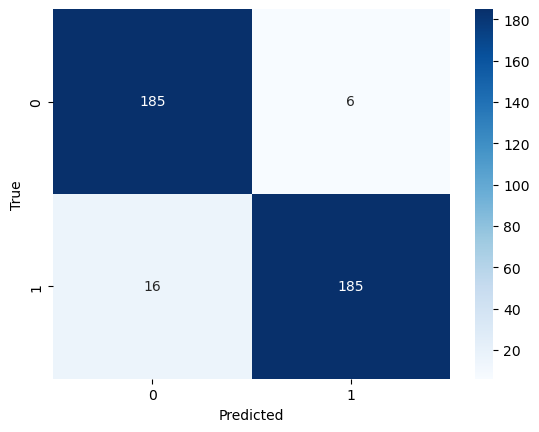

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_y, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# some inference

In [21]:
# lets do some predictions on the new user input text 
# we will use the same preprocessing steps as before
# we will use the same tokenizer as before
# we will use the same model as before

# just call the above preprocessing function on the new user input text 
# and then pass the preprocessed text to the model for prediction
inference_text = [ 'Check out this video on YouTube:Facebook']

encoded_dict = tokenizer_base_uncased.batch_encode_plus(inference_text, 
                                            add_special_tokens=True, 
                                            padding=True, 
                                            truncation=True, 
                                            max_length=10, 
                                            return_attention_mask=True, 
                                            return_tensors='pt')
encoded_dict

{'input_ids': tensor([[ 101, 4638, 2041, 2023, 2678, 2006, 7858, 1024, 9130,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [22]:
# convert the encoded dict values input_ids, token_type_ids, attention_mask to tensors for feeding into the model

input_ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long)
token_type_ids = torch.tensor(encoded_dict['token_type_ids'], dtype=torch.long)
attention_mask = torch.tensor(encoded_dict['attention_mask'], dtype=torch.long)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31268\1002175802.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31268\1002175802.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(encoded_dict['token_type_ids'], dtype=torch.long)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31268\1002175802.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded_dict['attentio

In [27]:
# pass the tensors to the model to get the predictions

with torch.no_grad():
    outputs = test_model(input_ids, attention_mask)
    logits = outputs[0]
    # get the index of the highest prediction
    prediction = torch.argmax(logits).item()
pred = 'Spam' if prediction == 1 else 'Not Spam/Ham'
print(f'The text is predicted to be {pred}')
# the predicted label is 1 which means the text is positive

The text is predicted to be Spam
